# This notebook uses pytorch lightning & optuna & an LSTM

This notebook trains an LSTM on timeseries data from smartmeters.

It uses pytorch lighting for the training loop. And Optuna for the hyperparameter optimisation.

It also pushes results to the tensorboard hyperparameter dashboard for examination.

- https://github.com/optuna/optuna/blob/master/examples/pytorch_lightning_simple.py

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import sys, re, os, itertools, functools, collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import pytorch_lightning as pl
import optuna
from optuna.integration import PyTorchLightningPruningCallback


import math


In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
from src.models.model import LatentModel
from src.data.smart_meter import collate_fns, SmartMeterDataSet, get_smartmeter_df
from src.plot import plot_from_loader
from src.models.transformer_seq2seq import TransformerSeq2Seq_PL
from src.dict_logger import DictLogger
from src.utils import  PyTorchLightningPruningCallback

/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/pytorch_lightning/core/decorators.py:13: UserWarning:

data_loader decorator deprecated in 0.7.0. Will remove 0.9.0



In [5]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("smartmeters.ipynb")

In [6]:
# Params
device='cuda'
use_logy=False

# Load kaggle smart meter data

In [7]:
df_train, df_test = get_smartmeter_df()

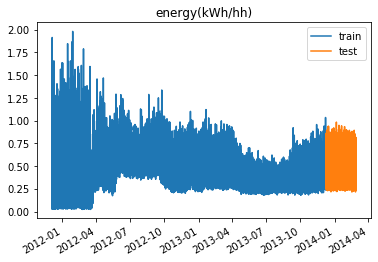

In [8]:
# Show split
df_train['energy(kWh/hh)'].plot(label='train')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Train helpers

In [9]:
def main(trial, train=True):
    # PyTorch Lightning will try to restore model parameters from previous trials if checkpoint
    # filenames match. Therefore, the filenames for each trial must be made unique.
    
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        os.path.join(MODEL_DIR, name, 'version_{}'.format(trial.number), "chk"), monitor='val_loss', mode='min')

    # The default logger in PyTorch Lightning writes to event files to be consumed by
    # TensorBoard. We create a simple logger instead that holds the log in memory so that the
    # final accuracy can be obtained after optimization. When using the default logger, the
    # final accuracy could be stored in an attribute of the `Trainer` instead.
    logger = DictLogger(MODEL_DIR, name=name, version=trial.number)
#     print("log_dir", logger.experiment.log_dir)
    hparams = dict(**trial.params, **trial.user_attrs)

    trainer = pl.Trainer(
        logger=logger,
        val_percent_check=PERCENT_TEST_EXAMPLES,
        checkpoint_callback=checkpoint_callback,
        max_epochs=hparams['max_nb_epochs'],
        gpus=-1 if torch.cuda.is_available() else None,
        early_stop_callback=PyTorchLightningPruningCallback(trial, monitor='val_loss')
    )
    
    model = TransformerSeq2Seq_PL(hparams)
    if train:
        trainer.fit(model)
    return model, trainer

In [10]:
def add_suggest(trial):
    trial.suggest_loguniform("learning_rate", 1e-7, 1e-2)
    trial.suggest_uniform("attention_dropout", 0, 0.75)
    trial.suggest_categorical("hidden_size", [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048])    
    trial.suggest_categorical("hidden_out_size", [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048])    
    trial.suggest_categorical("nlayers", [1, 2, 4, 8])    
    trial.suggest_categorical("nhead", [1, 2, 8, 16])
    

    trial._user_attrs = {
            'batch_size': 16,
            'grad_clip': 40,
            'max_nb_epochs': 200,
            'num_workers': 4,
            'num_extra_target': 24*4,
            'vis_i': '670',
            'num_context': 24*4,
            'input_size': 18,
            'input_size_decoder': 17,
            'context_in_target': True,
            'output_size': 1
    }
    
    # For manual experiment we will start at -1 and deincr by 1
    versions = [int(s.stem.split('_')[-1]) for s in (MODEL_DIR / name).glob('version_*')] + [-1]
    trial.number = min(versions)-1
    print('trial.number', trial.number)
    return trial

In [11]:

def objective(trial):
    # see https://github.com/optuna/optuna/blob/cf6f02d/examples/pytorch_lightning_simple.py
    trial = add_suggest(trial)

    
    print('trial', trial.number, 'params', trial.params)
    
    model, trainer = main(trial)
    
    # also report to tensorboard & print
    print('logger.metrics', model.logger.metrics[-1:])
    model.logger.experiment.add_hparams(trial.params, logger.metrics[-1])
    model.logger.save()
    
    return model.logger.metrics[-1]['val_loss']


# Train

In [12]:
PERCENT_TEST_EXAMPLES = 0.3
EPOCHS = 2
DIR = Path(os.getcwd())
name = "transformer_seq2seq"
MODEL_DIR = DIR/ 'lightning_logs'

MODEL_DIR.mkdir(parents=True, exist_ok=True)

In [13]:
print(f"now run `tensorboard --logdir {MODEL_DIR}")

now run `tensorboard --logdir /media/wassname/Storage5/projects2/3ST/attentive-neural-processes/lightning_logs


Note that the LSTM has access to the y values for the first half of the plot (the context) to match the NP setup.

trial.number -17
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
   | Name                                           | Type                    | Params
---------------------------------------------------------------------------------------
0  | model                                          | TransformerSeq2SeqNet   | 1 M   
1  | model.enc_emb                                  | Linear                  | 4 K   
2  | model.encoder                                  | TransformerEncoder      | 660 K 
3  | model.encoder.layers                           | ModuleList              | 660 K 
4  | model.encoder.layers.0                         | TransformerEncoderLayer | 330 K 
5  | model.encoder.layers.0.self_attn               | MultiheadAttention      | 263 K 
6  | model.encoder.layers.0.self_attn.out_proj      | Linear                  | 65 K  
7  | model.encoder.layers.0.linear1                 | Linear                  | 32 K  
8  | model.encoder.layers.0.dropo

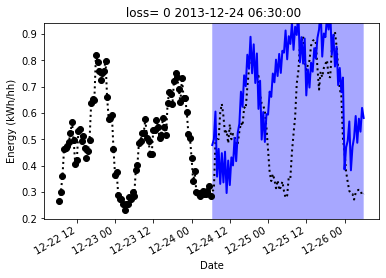

step 0, {'val_loss': '1.146193265914917', 'val/loss_mse': '0.1482062190771103', 'val/loss_p': '1.146193265914917', 'val/sigma': '1.196487307548523'}


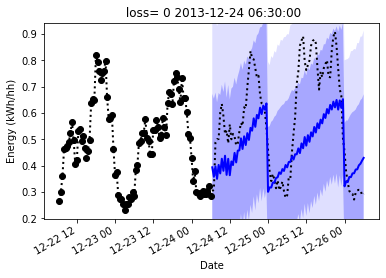

step 2194, {'val_loss': '-0.309064656496048', 'val/loss_mse': '0.023657485842704773', 'val/loss_p': '-0.309064656496048', 'val/sigma': '0.23991245031356812'}


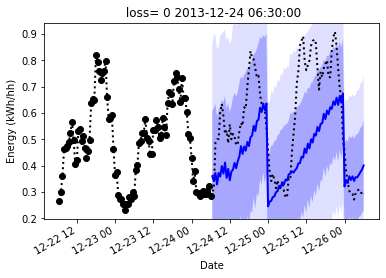

step 4389, {'val_loss': '-0.42497867345809937', 'val/loss_mse': '0.020270122215151787', 'val/loss_p': '-0.42497867345809937', 'val/sigma': '0.20783782005310059'}


In [ ]:
trial = optuna.trial.FixedTrial(
    params={
        'hidden_size': 128,
        'hidden_out_size': 256,
        'learning_rate': 2e-5,
        'attention_dropout': 0.0,
        'nlayers': 2,
        'nhead': 8
    })
trial = add_suggest(trial)
trial._user_attrs = {
        'batch_size': 16,
        'grad_clip': 40,
        'max_nb_epochs': 200,
        'num_workers': 4,
        'num_extra_target': 24*4,
        'vis_i': '670',
        'num_context': 24*4,
        'input_size': 18,
        'input_size_decoder': 17,
        'context_in_target': False,
        'output_size': 1
}
model, trainer = main(trial, train=False)
trainer.fit(model)

In [ ]:
# test
trainer.test(model)

In [ ]:
loader = model.val_dataloader()
dset_test = loader.dataset
label_names = dset_test.label_names
plot_from_loader(loader, model, i=670)

In [ ]:
# Look at input data, low temp, and holidays imply 
rows_x, rows_y = dset_test.get_rows(670)
rows_x[['apparentTemperature', 'holiday', 'dayofweek']].plot()

# Hyperparam opt

In [ ]:
import argparse 

parser = argparse.ArgumentParser(description='PyTorch Lightning example.')
parser.add_argument('--pruning', '-p', action='store_true',
                    help='Activate the pruning feature. `MedianPruner` stops unpromising '
                         'trials at the early stages of training.')
args = parser.parse_args(['-p'])

pruner = optuna.pruners.MedianPruner() if args.pruning else optuna.pruners.NopPruner()

study = optuna.create_study(direction='minimize', pruner=pruner, storage=f'sqlite:///optuna_result/{name}.db', study_name='no-name-b60e37fc-4ab6-4793-8a0a-c87a1b40c5c0', load_if_exists=True)

# shutil.rmtree(MODEL_DIR)

In [ ]:
study.optimize(objective, n_trials=200, timeout=6000)

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

In [ ]:
study.optimize(objective, n_trials=200, timeout=6000)

In [ ]:
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
df.sort_values('value')

# Scratch

In [ ]:
model, trainer = main(trial, train=False)

In [ ]:
loader = model.val_dataloader()[0]
dset_test = loader.dataset
label_names = dset_test.label_names

In [ ]:
x_rows, y_rows = dset_test.iloc(10)
x_rows.loc[x_rows.index[model.hparams.window_length:], dset_test.label_names] = 0.
x_rows

In [ ]:
x_rows.loc[x_rows.index[model.hparams.window_length:]]

In [ ]:
self=dset_test
idx=10
k = idx + self.hparams.window_length + self.hparams.target_length
j = k - self.hparams.target_length
i = j - self.hparams.window_length
idx, k, j, i, self.hparams.window_length + self.hparams.target_length

In [ ]:
j-i

In [ ]:
self.hparams.window_length + self.hparams.target_length